<a href="https://colab.research.google.com/github/ArtyKrafty/Kraftyy/blob/main/%D0%92%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%9C%D0%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тариф "Ултра" и "Смарт".  

Необходимо построить модель для задачи классификации, которая выберет подходящий тариф для клиента. 

Выходные данные передаваться никуда не будут, конечная цель - построение модели. В качестве критериев качества выберем `Accuracy` и `F1-score` - `Recall` и `Precision` отдельно смотреть не будем, проверку будем проводить с помощью тестового и валидационного набора данных без кросс-валидации.

*Примечание* пороговая правильность `0.75`


## Загрузка библиотек и файла
### Осмотр структуры файла

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

Загрузим данные и посмотрим первые 5 строк для изучения объектов и атрибутов

In [ ]:
!gdown --id 1nPVCuV-apX3lcUfXsIerJVfEpL9TFkR8

Downloading...
From: https://drive.google.com/uc?id=1nPVCuV-apX3lcUfXsIerJVfEpL9TFkR8
To: /content/users_behavior.csv
100% 134k/134k [00:00<00:00, 682kB/s]


In [ ]:
users = pd.read_csv('/content/users_behavior.csv')
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:  

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)  

Применим метод `info()` для получения краткого описания данных, их типа и количества, а также наличия пропусков:

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В наборе данных 3214 строк. Достаточно мало, но попробовать построить модель можно. Пропусков нет, типы данных менять не требуется. Проверим дубликаты:

In [ ]:
users.duplicated().sum()

0

Посмотрим количества абонентов по тарифам:

In [ ]:
users['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Применим метод `describe()` для получения информации о столбцах и разбросе значений:

In [ ]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Построим гистограммы для всех атрибутов, чтобы посмотреть диапазон значений:

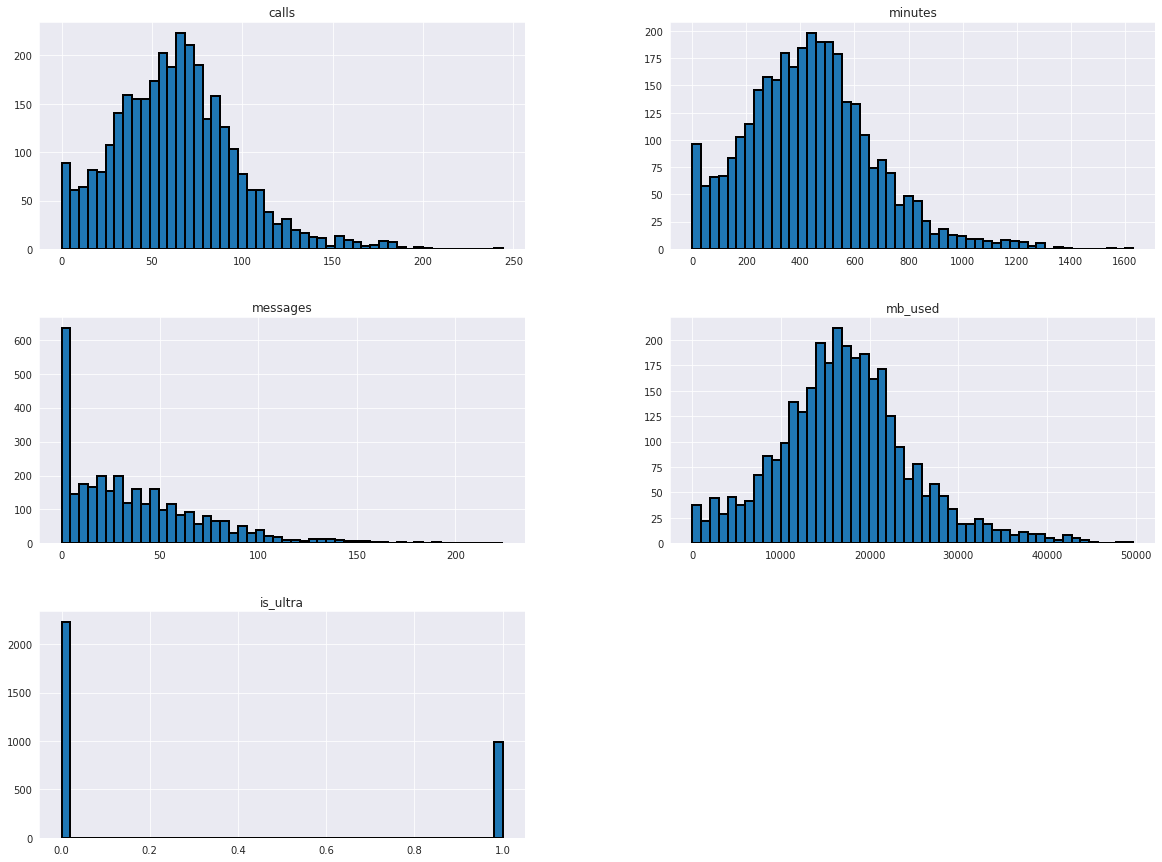

In [ ]:
users.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

In [ ]:
print('Контрольная сумма строк:', len(users))

Контрольная сумма строк: 3214


### Вывод

Критичных аномалий не выявлено, пропусков нет, дубликатов нет. Контрольное количество строк - 3214. Гистограммы положительно скошенные, имеют медленно убывающие хвосты, но в целом распределения достаточно близкие к колокообразным для целей МО. 

Преждем чем продолжить изучение данных необходимо разделить выборку на обучающую, валидационную и тестовую. Чтобы не допустить смещения из-за информационного просмотра данных - тестовую выборку отложим. Обратимся к ней в самом конце проекта после настройки моделей.

## Создание образцов данных

Для создания стратифицированных выборок данных недостаточно, поэтому применим функцию библиотеки `sklearn` - `train_test_split` и разделим данные случайным образом, сохранив одинаковые доли абонентов. Для начала создадим тестовый набор данных, который отложим до конца работы и получим новый сет, из которого отберем валидационную выборку и обучающую для построения и настройки модели.

### Создание тестового образца

In [ ]:
train, test_set = train_test_split(users, test_size=0.2, random_state=42)

Новый сет разделим на обучающую и валидационную выборки:

### Создание валидационного и обучающего образцов

In [ ]:
train_set, valid_set = train_test_split(train, test_size=0.25, random_state=42)

In [ ]:
print('Размер обучающей выборки', len(train_set))
print('Размер валидационной выборки', len(valid_set))
print('Размер тестовой выборки', len(test_set))

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


In [ ]:
len(users) - (len(test_set) + len(train_set) + len(valid_set))

0

Строки не потеряли, напишем функцию определения долей абонентов по выборкам для контроля и посмотрим эти доли:

In [ ]:
def prop (data, column, set_name):
    result = round((data[column].sum()/len(data[column])*100), 2)
    return print(f'Доля в % абонентов «Ультра» в выборке {set_name}:',result)

In [ ]:
prop(train_set,'is_ultra', '"Тренировочный набор"')
prop(valid_set,'is_ultra', '"Валидационный набор"')
prop(test_set,'is_ultra', '"Тестовый набор"')
prop(users,'is_ultra', '"Исходный набор"')

Доля в % абонентов «Ультра» в выборке "Тренировочный набор": 31.38
Доля в % абонентов «Ультра» в выборке "Валидационный набор": 29.86
Доля в % абонентов «Ультра» в выборке "Тестовый набор": 29.24
Доля в % абонентов «Ультра» в выборке "Исходный набор": 30.65


Перед построением моделей посмотрим наш начальный сет данных на предмет зависимостей

In [ ]:
users.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Сильная корреляция наблюдается между количеством звонков и минутами, что довольно логично. На первый взгляд выявить какую либо связь между артибутами и признаком Ультра не вышло. Визуализируем данные значения. По остальным атрибутам наблюдается низкая корреляция. Так или иначе - цель модели - классификация, задачи регрессии не ставилось

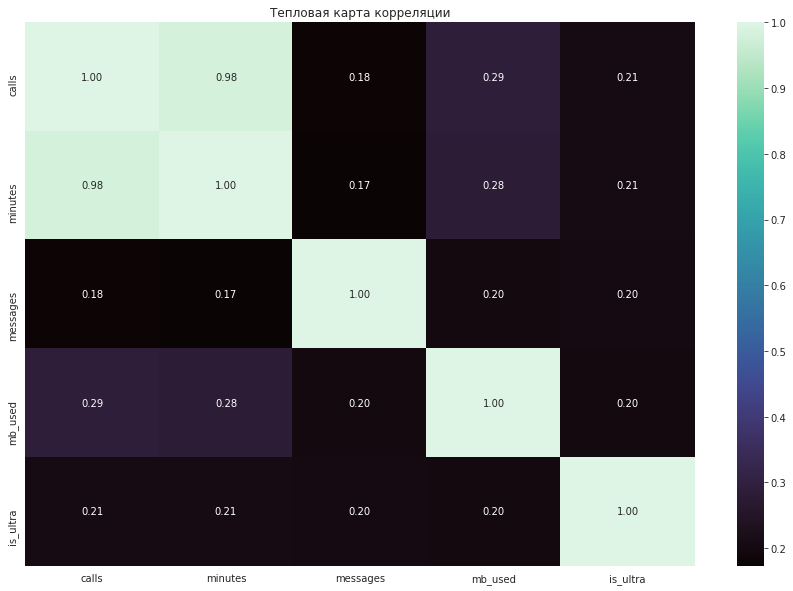

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(users.corr(),annot=True, cmap='mako', fmt='.2f')
plt.title('Тепловая карта корреляции')
plt.show()

### Вывод

Разделили выборку на три части: 60% - обучающий набор, 20% - валидационный набор, 20% - тестовый набор. Тестовый набор не смотрим, убрали до конца исследования. Доли абонентов сохранили, примерно равны по выборкам, корреляции сильной не наблюдается, кроме атрибутов звонков и минут, что довольно логично. Осмотр данных обучающего столбца аномалий не показал, можно приступать к исследованию моделей.

## Исследование моделей

Напишем функцию разделения выборки на целевой атрибут и атрибуты со свойствами (target и features)

In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

Разделим нашу обучающую выборку для построение моделей:

In [ ]:
df_features, df_target = split_data(train_set,'is_ultra')
valid_features, valid_target = split_data(valid_set,'is_ultra')

### Деревья принятия решений

#### Базовое дерево

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

NameError: ignored

На тестовой выборке правильность ниже, дерево переобучается, необходимо настроить параметры и гиперпараметры. Сделаем это с помощью функции `GridSearchCV`, настраивает и подбирать будем минимальное число самплов для разделения и глубину дерева, оценивать будем по правильности:

In [ ]:
param_grid = {'min_samples_split': range(2, 15),
              'max_depth': [None, 6, 7, 8, 9, 10]
             }

model = DecisionTreeClassifier (random_state=42)

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(df_features, df_target)

In [ ]:
grid_search.best_params_

Получили значения гиперпараметров для дерева. Применим

#### Дерево с настройками

In [ ]:
model_dtree = DecisionTreeClassifier(max_depth=7, min_samples_split=3, random_state=42)
model_dtree.fit(df_features, df_target)


valid_predictions = model_dtree.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7884914463452566


#### Вывод

С данными параметрами дерево более правильным. С этими параметрами будем испытывать дерево на тестовой выборке: `'max_depth': 7, 'min_samples_split': 3`

### Логистическая регрессия

#### Базовая Логистическая регрессия

Построим базовую модель для целей классификации на основе логистической регрессии, параметр `solver` примем как 'liblinear', так как выборка небольшая. Менять его не будем

In [ ]:
model = LogisticRegression(solver='liblinear',random_state=42)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")

print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7216174183514774


Модель показала хороший результат, но наш порог 0.75 - необходимо настроить модель, но мы видим что она не переобучается и недообучается. Настроим параметр `intercept_scaling` - для улучшения solver, `class_weight`, `C` - для дополнительного регулирования

In [ ]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=42)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='accuracy')
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
grid_search.best_params_

{'C': 1.5, 'class_weight': None, 'intercept_scaling': 1.5}

#### Логистическая регрессия с настройками

In [ ]:
model_lreg = LogisticRegression(C=1.5, class_weight=None, intercept_scaling=1.5,
                           solver='liblinear', random_state=42
                          )
model_lreg.fit(df_features, df_target)


valid_predictions = model_lreg.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")

print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7465007776049767


#### Вывод  

Модель сильно не улучшилась, мы находимся на пороге правильности. Модель не очень хорошо себя ведет с этими данными. Проверим на тестовой выборке с найденными параметрами и оценим модель.

### Случайные леса

#### Базовые Случайные леса  

Построим модель на основе случайного леса, применим старую версию дефолтного значения эстиматоров - 10 (в версии 0.22 - 100), так как данных у нас немного:

In [ ]:
model = RandomForestClassifier(random_state=42, n_estimators=10)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7667185069984448


Правильность чуть превысила порог 0.75. Посмотрим в дальнейшем как модель поведет себя на тестовой выборке

In [ ]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
grid_search.best_params_

{'criterion': 'entropy', 'min_samples_split': 14, 'n_estimators': 30}

#### Случайные леса с настройками

In [ ]:
model_rfc = RandomForestClassifier(random_state=42, criterion='gini', 
                               min_samples_split=12, n_estimators=30
                              )
model_rfc.fit(df_features, df_target)

valid_predictions = model_rfc.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.8009331259720062


#### Вывод  

Правильность незначительно увеличилась. Возьмем модель с этими параметрами

### k ближайших соседей

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")

print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.749611197511664


In [ ]:
par_grid_kneigh = {
                   'n_neighbors': [5,10,15],
                   'leaf_size': [1,3,5],
                   'weights': ['uniform', 'distance'],
                   'algorithm': ['ball_tree', 'kd_tree']
                   }
model = KNeighborsClassifier()

grid_search = GridSearchCV(model, par_grid_kneigh, cv=5,
                           scoring='accuracy')
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [1, 3, 5], 'n_neighbors': [5, 10, 15],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
grid_search.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 15,
 'weights': 'uniform'}

In [ ]:
model_kn = KNeighborsClassifier(algorithm = 'ball_tree',
                             leaf_size= 1,
                             n_neighbors= 15,
                             weights='uniform'
                            )
model_kn.fit(df_features, df_target)


valid_predictions = model_kn.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7651632970451011


Порог правильности превысили, посмотрим как модель себя поведет на тесте

### Catboost

Попробуем построить модель на основе open source библиотеки Catboost. Так как рассчет занимает продолжительное время относительно остальных классификаторо, подбирать параметры не будем, сделаем данную модель информационно

In [ ]:
model_cat = CatBoostClassifier(verbose=100, random_state=42)
model_cat.fit(df_features, df_target)


valid_predictions = model_cat.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Learning rate set to 0.013636
0:	learn: 0.6869397	total: 49.8ms	remaining: 49.7s
100:	learn: 0.4683207	total: 249ms	remaining: 2.22s
200:	learn: 0.4289193	total: 443ms	remaining: 1.76s
300:	learn: 0.4091795	total: 646ms	remaining: 1.5s
400:	learn: 0.3939299	total: 836ms	remaining: 1.25s
500:	learn: 0.3804989	total: 1.03s	remaining: 1.03s
600:	learn: 0.3671992	total: 1.22s	remaining: 813ms
700:	learn: 0.3526519	total: 1.42s	remaining: 605ms
800:	learn: 0.3390020	total: 1.61s	remaining: 400ms
900:	learn: 0.3240903	total: 1.8s	remaining: 198ms
999:	learn: 0.3107701	total: 2.02s	remaining: 0us
Accuracy
Валидационная выборка: 0.8087091757387247


#### Вывод. 

Catboost переобучается, но при этом показаывает самую высокую правильность на валидационной выборке. Применим модель в таком виде на тестовых данных

## Проверка моделей на тестовой выборке

Разделим тестовую выборку на целевой атрибут и атрибуты для классификации

In [ ]:
test_features, test_target = split_data(test_set,'is_ultra')

In [ ]:
#для удобства вывода в дальнейшем - соберем показатели в списки
table_of_acc = []
table_of_model = []
table_of_prec = []

### Дерево принятия решений

In [ ]:
test_predictions = model_dtree.predict(test_features)
test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('DecisionTreeClassifier')


Accuracy
Тестовая выборка: 0.7993779160186625
F1-мера
Тестовая выборка: 0.7832868454436918


На тестовой выборке показывает хорошую правильность и меру F1, выше порога 0.75, данная модель примененим для нашей цели

### Логистическая регрессия

In [ ]:

test_predictions = model_lreg.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Тестовая выборка: 0.7589424572317263
F1-мера
Тестовая выборка: 0.714696906926984


На тестовой выборке логистическая регрессия показывает правильность чуть выше пороговой, но при этом F1 мера хуже, чем у дерева. На данный момент лучшая модель - на основе дерева приятия решений

### Случайный лес

In [ ]:

test_predictions = model_rfc.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Тестовая выборка: 0.807153965785381
F1-мера
Тестовая выборка: 0.7988221948898717


Случайный лес показывает отличные результаты. На данный момент - лучшие, по сравнению даже с дерево принятия решений

### k ближайших соседей

In [ ]:

test_predictions = model_kn.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions)
print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('KNeighborsClassifier')

Accuracy
Тестовая выборка: 0.7807153965785381
F1-мера
Тестовая выборка: 0.4797047970479706


У к-ближайших соседей очень низкая F1 мера, хоть порог и пройден, но данную модель лучше оставить в данном случае

### Catboost

In [ ]:

test_predictions = model_cat.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('CatBoostClassifier')

Accuracy
Тестовая выборка: 0.80248833592535
F1-мера
Тестовая выборка: 0.7911961254730326


Catboost показывает лучшие результаты по классификации среди моделей. Сведем все в таблицу:

In [ ]:
table_of_models = (pd.DataFrame({'Model':table_of_model, 'Accuracy':table_of_acc, 
                                'F1 score':table_of_prec}).sort_values(by='Accuracy', ascending=False).
                  reset_index(drop=True))
table_of_models

,Model,Accuracy,F1 score
0,RandomForestClassifier,0.81,0.80
1,DecisionTreeClassifier,0.80,0.78
2,CatBoostClassifier,0.80,0.79
3,KNeighborsClassifier,0.78,0.48
4,LogisticRegression,0.76,0.71


### Вывод  

Лучшая модель для целей классификации на основе данных по тарифам является модель на библиотеке Catboost, далее идет модель на основе Случайного леса, далее - Дерево принятия решений. k ближайших соседей и логистическая регрессия показали недостаточно хорошие результаты по F1 мере, поэтому несмотря на тот факт, что порог правильности превышен - их не следует применять для задачи классификации в данном случае.

## Проверка модели на вменяемость

Проверим модели на вменяемость. Для это построим случайную модель на основе DummyClassifier, попробуем посмотреть количественные характеристики по выборке столбца `is_ultra`

In [ ]:
table_of_models

,Model,Accuracy,F1 score
0,RandomForestClassifier,0.81,0.80
1,DecisionTreeClassifier,0.80,0.78
2,CatBoostClassifier,0.80,0.79
3,KNeighborsClassifier,0.78,0.48
4,LogisticRegression,0.76,0.71


### Dummy классификатор (рандомный)

Переберем через цикл различные значения стратегий для данного алгоритма и сравним результаты с нашими моделями:

In [ ]:
strategies = ['most_frequent', 'stratified', 'uniform']
dummies_result = []
for strat in strategies:
    dc = DummyClassifier(strategy=strat, random_state=42)
    dc.fit(df_features, df_target)
    res = dc.score(test_features, test_target)
    dummies_result.append({strat:res})

pd.DataFrame(dummies_result).fillna(0)



,most_frequent,stratified,uniform
0,0.707621,0.000000,0.000000
1,0.000000,0.562986,0.000000
2,0.000000,0.000000,0.493002


Самый лучший вариант, что мы получили алгоритмом - 0.71, в то время как наши модели показывают правильность больше 0.75. 

### Сравнение через .shape[0] с начальной выборкой

Наши модели считают количество угадывания, поэтому можем посмотреть количество по столбцу 'is_ultra' и оценить  доли:

In [ ]:
(users['is_ultra'].value_counts()/users.shape[0]).to_frame()

,is_ultra
0,0.693528
1,0.306472


Доля клиентов с тарифом "Ультра" в начальной выборке 0.69. Наши модели показывают большую точность, они выявили закономерности, позволяющие предложить новым пользователям тариф

### Ручная модель

Попробуем построить ручную модель, посмотрим нашу таблицу еще раз (отобранную тренировочную выборку)

In [ ]:
train_set.head()

,calls,minutes,messages,mb_used,is_ultra
3187,35.0,259.10,4.0,14857.57,0
1889,84.0,574.03,0.0,16028.42,0
1253,62.0,446.89,7.0,21571.89,0
1147,75.0,511.02,49.0,17120.31,0
2801,34.0,279.06,83.0,13463.84,0


Скопируем ее и посмотрим корреляции, возможно нам это поможет выделить паттерны

In [ ]:
df_man = train_set.copy()
df_man.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982413,0.183205,0.291584,0.225257
minutes,0.982413,1.000000,0.179284,0.287777,0.232492
messages,0.183205,0.179284,1.000000,0.213284,0.219989
mb_used,0.291584,0.287777,0.213284,1.000000,0.201764
is_ultra,0.225257,0.232492,0.219989,0.201764,1.000000


Сильной коррелляции нигде не наблюдаем, кроме минут и звонков. Предположим, что пользователи чаще тратят минуты и мегабайты и поэтому используют тариф "Ультра"

In [ ]:
df_man.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,1928.0,63.267635,33.567751,0.0,40.0000,63.000,83.0000,244.00
minutes,1928.0,439.972910,237.849926,0.0,272.8225,430.090,578.2175,1632.06
messages,1928.0,38.260373,37.041732,0.0,9.0000,29.000,56.0000,224.00
mb_used,1928.0,17258.155690,7613.359618,0.0,12431.9450,17099.865,21420.6500,49745.73
is_ultra,1928.0,0.313797,0.464155,0.0,0.0000,0.000,1.0000,1.00


In [ ]:
df_man['minutes'].describe()

count    1928.000000
mean      439.972910
std       237.849926
min         0.000000
25%       272.822500
50%       430.090000
75%       578.217500
max      1632.060000
Name: minutes, dtype: float64

In [ ]:
df_man['mb_used'].describe()

count     1928.000000
mean     17258.155690
std       7613.359618
min          0.000000
25%      12431.945000
50%      17099.865000
75%      21420.650000
max      49745.730000
Name: mb_used, dtype: float64

Выделим группы методом qcut и присвоим им обозначения по индексу

In [ ]:
min_ser, min_bin = pd.qcut(df_man['minutes'],5, retbins=True, labels=False)
mb_ser, mb_bin = pd.qcut(df_man['mb_used'],5, retbins=True, labels=False)


Теперь мы можем добавить столбцы с обозначением группы в нашу таблицу

In [ ]:
df_man['min_bin'] = min_ser
df_man['mb_bin'] = mb_ser

In [ ]:
df_man.head(20)

,calls,minutes,messages,mb_used,is_ultra,min_bin,mb_bin
3187,35.0,259.10,4.0,14857.57,0,1,1
1889,84.0,574.03,0.0,16028.42,0,3,2
1253,62.0,446.89,7.0,21571.89,0,2,3
1147,75.0,511.02,49.0,17120.31,0,3,2
2801,34.0,279.06,83.0,13463.84,0,1,1
2330,13.0,80.80,9.0,2861.00,0,0,0
3000,123.0,967.93,0.0,14194.09,1,4,1
1494,67.0,499.87,69.0,32556.54,1,3,4
882,66.0,494.47,0.0,17360.07,0,3,2
2352,32.0,283.13,60.0,19223.32,0,1,3


Через сводную таблицу посмотрим средние значения пользователей тарифа "Ультра" на пересечения минут и мегабайт:

In [ ]:
df_man.pivot_table(columns=['min_bin'],index=['mb_bin'], values='is_ultra', aggfunc='mean')

min_bin,0,1,2,3,4
mb_bin,,,,,
0,0.244048,0.406250,0.272727,0.290909,0.800000
1,0.250000,0.147368,0.136364,0.138889,0.375000
2,0.178571,0.128205,0.153846,0.202247,0.347222
3,0.302326,0.123596,0.141026,0.166667,0.544304
4,0.597015,0.542373,0.253968,0.493151,0.790323


Напишем функцию для категорирования. В процессе работы выяснили*, что наилучший порог среднего значения для добавления категории 1 Ультра - 0.29, запишем наши значения в функцию:  
  

*Примечание*: *начинали принимать в классификацию с порога 0.15 для среднего значения пользователей, потом сранивали правильность - наилучшую получили при включении значений свыше 0.29 для среднего, что и отражено в функции по пересечению индекса и колонок сводной таблицы*  

*Смысл в том, что включали в функцию все значения среднего свыше 0.15 сначала и обозначали это как 1 - Ультра. Методом подбора и сравнения - выяснили - что лучшие показатели достигаются при 0.29. Но это отняло много времени, при этом функция уже имеет готовый, вид, перебор не стали включать. Например, при включении всех ячеек с средним свыше 0.15 - правильнсть accuracy была 0.39 всего*

In [ ]:
def ultra_cat(row):

    if row['min_bin'] >= 3 and row['mb_bin'] == 0:
        return 1
    elif row['min_bin'] == 4 and row['mb_bin'] == 1:
        return 1
    elif row['min_bin'] == 4 and row['mb_bin'] == 2:
        return 1
    elif row['min_bin'] == 4 and row['mb_bin'] == 3:
        return 1
    elif row['min_bin'] !=2 and row['mb_bin'] == 4:
        return 1
    else:
        return 0

Применили функцию, получим выборку с предсказанными категориями 

In [ ]:
df_man['is_ultra_prd'] = df_man.apply(ultra_cat, axis=1)
df_man.head(10)


,calls,minutes,messages,mb_used,is_ultra,min_bin,mb_bin,is_ultra_prd
3187,35.0,259.10,4.0,14857.57,0,1,1,0
1889,84.0,574.03,0.0,16028.42,0,3,2,0
1253,62.0,446.89,7.0,21571.89,0,2,3,0
1147,75.0,511.02,49.0,17120.31,0,3,2,0
2801,34.0,279.06,83.0,13463.84,0,1,1,0
2330,13.0,80.80,9.0,2861.00,0,0,0,0
3000,123.0,967.93,0.0,14194.09,1,4,1,1
1494,67.0,499.87,69.0,32556.54,1,3,4,1
882,66.0,494.47,0.0,17360.07,0,3,2,0
2352,32.0,283.13,60.0,19223.32,0,1,3,0


Предскажем значения на тестовой выборке

In [ ]:
test_features.head()

,calls,minutes,messages,mb_used
506,46.0,338.60,35.0,11428.54
2513,39.0,242.71,0.0,20480.11
354,39.0,258.02,0.0,19998.80
1080,36.0,230.99,19.0,23525.07
2389,35.0,205.35,52.0,35177.94


In [ ]:
test_features_man = test_features.copy()

Разобьем тестовую выборку на категории с аналогичным разделением как в мы делали выше с df_man, корзины мы посчитали ранее, укажем их в аргументах:

In [ ]:
test_features_man['min_bin'] = pd.cut(test_features_man['minutes'], bins = min_bin, labels=False, include_lowest=True)
test_features_man['mb_bin'] = pd.cut(test_features_man['mb_used'], bins = mb_bin, labels=False, include_lowest=True)

In [ ]:
test_features_man.head()

,calls,minutes,messages,mb_used,min_bin,mb_bin
506,46.0,338.60,35.0,11428.54,1,1
2513,39.0,242.71,0.0,20480.11,1,3
354,39.0,258.02,0.0,19998.80,1,3
1080,36.0,230.99,19.0,23525.07,0,4
2389,35.0,205.35,52.0,35177.94,0,4


Создадим нашу ручную модель:

In [ ]:
model_man = df_man[['mb_bin', 'min_bin', 'is_ultra_prd']].reset_index(drop=True)
model_man.head()


,mb_bin,min_bin,is_ultra_prd
0,1,1,0
1,2,3,0
2,3,2,0
3,2,3,0
4,1,1,0


Проверим работу модели по тем же самым параметрам, что и модели МО

In [ ]:
test_features_man['is_ultra_pred']= test_features_man.apply(ultra_cat, axis=1)

pred = test_features_man['is_ultra_pred'].to_numpy()
test_acc = accuracy_score(test_target, pred)
test_f1 = f1_score(test_target, pred, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)

Accuracy
Тестовая выборка: 0.7262830482115086
F1-мера
Тестовая выборка: 0.7286869408035022


In [ ]:
df_man_targ = df_man['is_ultra'].to_numpy()
df_man['is_ultra_pred'] = df_man.apply(ultra_cat, axis=1)

pred_df = df_man['is_ultra_pred'].to_numpy()
df_test_acc = accuracy_score(df_man_targ, pred_df)
df_test_f1 = f1_score(df_man_targ, pred_df, average='weighted')

print("Accuracy")
print("Тренировочная выборка:", df_test_acc)
print("F1-мера")
print("Тренировочная выборка:", test_f1)

Accuracy
Тренировочная выборка: 0.7225103734439834
F1-мера
Тренировочная выборка: 0.7286869408035022


Наша ручная модель не дотягивает до порога правильности 0.75, при этом это самые лучшие результаты, что смогли получить

### Вывод

Модель на основе случайности и ручная модель не смогли пройти порог правильности 0.75, в отличии от моделей Машинного обучения. Таким образом, модели МО лучше применимы в ситуации классификации на этих данных, показывая большую правильность, соответственно и рекомендации будут точнее, модели МО - вменяемы

## Общий вывод

Для классификации пользователей по тарифам и предложения им перехода на тот или иной тариф - лучше всего прменять модель на основе Catboost, при этом эта модель не требует даже дополнительной настройки - показала себя наиболее правильной.   

Также подходят для данной задачи Случайный лес и Дерево принятия решений. Логистическая регрессия и k ближайших сосдей показали себя недостаточно хорошо, применять для данной задлачи их не стоит. Переда нами стояла задача построения модели - поэтому ее не сохраняли, передавать модель не требуется. 

Ниже приводим таблицу достигнутой правильности:

In [ ]:
table_of_models

,Model,Accuracy,F1 score
0,RandomForestClassifier,0.81,0.80
1,DecisionTreeClassifier,0.80,0.78
2,CatBoostClassifier,0.80,0.79
3,KNeighborsClassifier,0.78,0.48
4,LogisticRegression,0.76,0.71
